# Copula Notes

## Introduction

A copula is a function which couples a multivariate distribution function to its marginal distribution functions, generally called marginals or simply margins. Copulas are great tools for modelling and simulating correlated random variables.

The main appeal of copulas is that by using them you can model the correlation structure and the marginals (i.e. the distribution of each of your random variables) separately. This can be an advantage because for some combination of marginals there are no built-in functions to generate the desired multivariate distribution. For instance, in R it is easy to generate random samples from a multivariate normal distribution, however it is not so easy to do the same with say a distribution whose margins are Beta, Gamma and Student, respectively.
Furthermore, as you can probably see by googling copulas, there is a wide range of models providing a set of very different and customizable correlation structures that can be easily fitted to observed data and used for simulations.

## How Copula works

We generate n samples from a multivariate normal distribution of 3 random variables given the covariance matrix sigma using the MASS package.

In [3]:
library(MASS)
set.seed(100)

m <- 3
n <- 2000
sigma <- matrix(c(1, 0.4, 0.2,
                  0.4, 1, -0.8,
                  0.2, -0.8, 1), 
                nrow=3)
z <- mvrnorm(n,mu=rep(0, m),Sigma=sigma,empirical=T)

Now we check the samples correlation using cor() and a pairplot.
We are going to set method='spearman' in order to use Spearman’s Rho instead of the 'pearson' method in the cor() function (this is not strictly necessary in our example since we are going to use an elliptical copula, if you use non-elliptical copulas you may want to use either Spearman’s Rho or Kendall’s Tau).

1.0000000,0.3812244,0.1937548
0.3812244,1.0000000,-0.7890814
0.1937548,-0.7890814,1.0000000


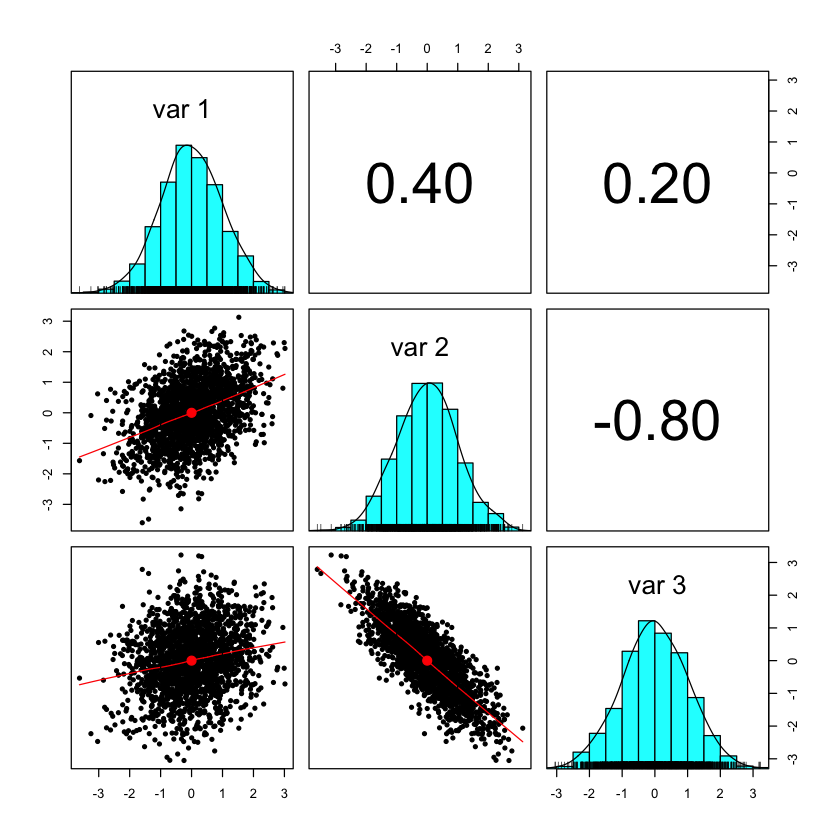

In [4]:
library(psych)
cor(z,method='spearman')
pairs.panels(z)

The output and the pairplot show us that indeed our samples have exactly the expected correlation structure.
Rplot

And now comes the magic trick: recall that if (X) is a random variable with distribution (F) then (F(X)) is uniformly distributed in the interval [0, 1]. In our toy example we already know the distribution (F) for each of the three random variables so this part is quick and straightforward.